# Importing the necessary libraries

In [11]:
import os
import torch
from torchvision.transforms import functional as F
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import seaborn as sns
import matplotlib.pyplot as plt
from easyimages import EasyImageList
from torchvision import models
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from sklearn.metrics import confusion_matrix

# Retrieving the preprocessed train, test and validation splits

In [3]:
preprocessed_images_dir = os.path.join(os.getcwd(), 'data_preprocessing_image_classification')
train_dir = os.path.join(preprocessed_images_dir, 'train')
val_dir = os.path.join(preprocessed_images_dir, 'validation')
test_dir = os.path.join(preprocessed_images_dir, 'test')

## Converting the images to tensors

class_dict is the same across all directories.

In [4]:
def get_tensors(dir):
    class_dict = {}
    label_dict = {}
    image_dict = {}
    bbox_dict = {}
    img_index = 0 
    subdirs = [d for d in os.listdir(dir) if d != '.DS_Store']
    for class_index, class_dir_name in enumerate(subdirs):
        class_dict[class_dir_name] = class_index
        class_dir = os.path.join(dir, class_dir_name)
        class_imgs = os.listdir(class_dir)
        for img_file in class_imgs:
            if img_file.endswith('.jpg'):
                img_path = os.path.join(class_dir, img_file)
                img = Image.open(img_path).convert('L') #not all images are greyscale for some reason...
                img_tensor = F.to_tensor(img)
                image_dict[img_index] = img_tensor
                bbox = [0, 0, 128, 128]
                bbox_tensor = torch.tensor([bbox], dtype = torch.float32)
                bbox_dict[img_index] = bbox_tensor
                class_label_tensor = torch.tensor([class_index])
                label_dict[img_index] = class_label_tensor
                img_index += 1
    return class_dict, image_dict, bbox_dict, label_dict
        
train_class_dict, train_image_dict, train_bbox_dict, train_label_dict = get_tensors(train_dir)
val_class_dict, val_image_dict, val_bbox_dict, val_label_dict = get_tensors(val_dir)
test_class_dict, test_image_dict, test_bbox_dict, test_label_dict = get_tensors(test_dir)

## Defining and using a custom Torch dataset class

In [5]:
class CustomDataset(Dataset):
    def __init__(self, class_dict, image_dict, bbox_dict, label_dict):
        self.class_dict = class_dict
        self.image_dict = image_dict
        self.bbox_dict = bbox_dict
        self.label_dict = label_dict
        self.keys = list(image_dict.keys())
        
    def __len__(self):
        return len(self.keys)
    
    def __getitem__(self, idx):
        class_tensor = self.class_dict
        img_tensor = self.image_dict[self.keys[idx]]
        bbox_tensor = self.bbox_dict[self.keys[idx]]
        label_tensor = self.label_dict[self.keys[idx]]
        return class_tensor, img_tensor, bbox_tensor, label_tensor

In [6]:
train_dataset = CustomDataset(train_class_dict, train_image_dict, train_bbox_dict, train_label_dict)
val_dataset = CustomDataset(val_class_dict, val_image_dict, val_bbox_dict, val_label_dict)
test_dataset = CustomDataset(test_class_dict, test_image_dict, test_bbox_dict, test_label_dict)

## Exploratory Data Analysis after Augmentation

### 1) Visualizing the split distribution

/var/folders/v2/2zy99jps2r59h7j5b66dv7l40000gn/T/ipykernel_33460/50884834.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=['Train', 'Validation', 'Test'], y=[train_length, val_length, test_length], palette='Set1')


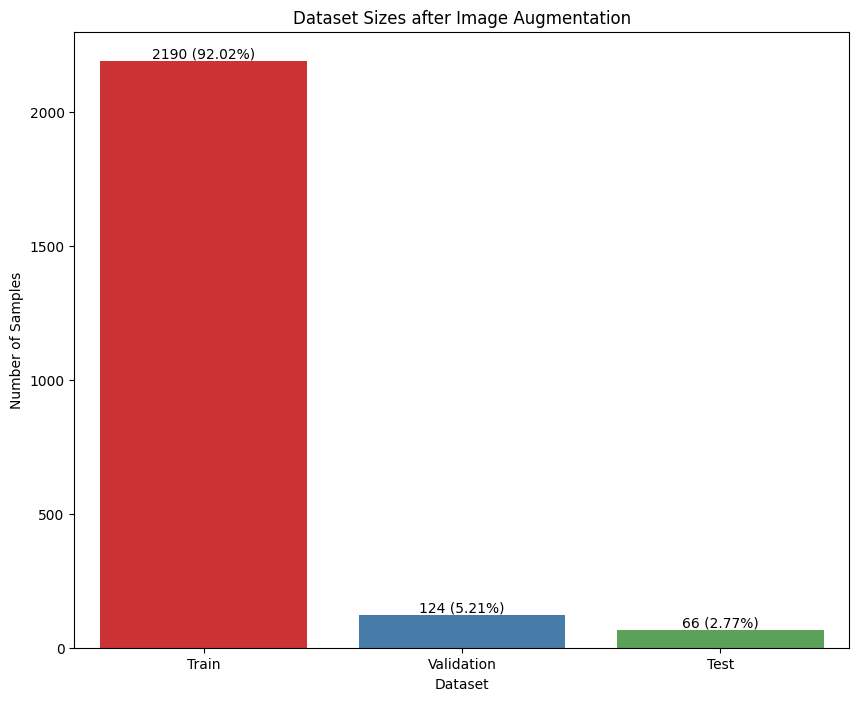

In [12]:
train_length = len(train_dataset)
val_length = len(val_dataset)
test_length = len(test_dataset)

total_length = train_length + val_length + test_length
train_percent = (train_length / total_length) * 100
val_percent = (val_length / total_length) * 100
test_percent = (test_length / total_length) * 100

plt.figure(figsize=(10, 8))

ax = sns.barplot(x=['Train', 'Validation', 'Test'], y=[train_length, val_length, test_length], palette='Set1')

for p, label, raw_number in zip(ax.patches, [train_percent, val_percent, test_percent], [train_length, val_length, test_length]):
    ax.annotate(f'{raw_number} ({label:.2f}%)', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.title('Dataset Sizes after Image Augmentation')
plt.xlabel('Dataset')
plt.ylabel('Number of Samples')
plt.show()

### 2) Looking at the images in the training data

#### For images of class 'glass'

In [8]:
Li = EasyImageList.from_folder(os.path.join(train_dir, 'glass'))
Li.symlink_images()
Li.html(sample=10, size=175)

#### For images of class 'metal'

In [13]:
Li = EasyImageList.from_folder(os.path.join(train_dir, 'metal'))
Li.symlink_images()
Li.html(sample=10, size=175)

#### For images of class 'plastic'

In [15]:
Li = EasyImageList.from_folder(os.path.join(train_dir, 'plastic'))
Li.symlink_images()
Li.html(sample=10, size=175)

#### For images of class 'paper'

In [16]:
Li = EasyImageList.from_folder(os.path.join(train_dir, 'paper'))
Li.symlink_images()
Li.html(sample=10, size=175)

## Loading the dataset into a Torch dataloader

In [17]:
batch_size = 128
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

## Self-trained model

A custom VGG11 model architecture will be used, where it only has 1 input channel as all pictures are in grayscale, with 4 output classes and softmax applied before prediction. None of the weights from the pretrained VGG11 will be carried over. Had to modify the LL input dim size as well to match having just one channel.

In [18]:
class VGG11(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(VGG11, self).__init__()
        self.in_channels = in_channels
        self.num_classes = num_classes
        # convolutional layers 
        self.conv_layers = nn.Sequential(
            nn.Conv2d(self.in_channels, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        # fully connected linear layers
        self.linear_layers = nn.Sequential(
            nn.Linear(in_features=8192, out_features=4096),
            nn.ReLU(),
            nn.Dropout2d(0.5),
            nn.Linear(in_features=4096, out_features=4096),
            nn.ReLU(),
            nn.Dropout2d(0.5),
            nn.Linear(in_features=4096, out_features=self.num_classes)
        )
    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

In [47]:
VGG11_model = VGG11(1, 4)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(VGG11_model.parameters(), lr=0.001)
epochs = 3

total_params = sum(p.numel() for p in VGG11_model.parameters())
print("Total parameters:", total_params)
total_trainable_params = sum(
    p.numel() for p in VGG11_model.parameters() if p.requires_grad)
print("Trainable parameters:", total_trainable_params)

Total parameters: 59575556
Trainable parameters: 59575556


In [48]:
batch_loss = []
VGG11_model.train()
for epoch in range(1, epochs+1):
    for class_tensor, img_tensor, bbox_tensor, label_tensor in tqdm(train_dataloader):
        inputs = img_tensor
        targets = label_tensor.squeeze()
        optimizer.zero_grad()
        logits = VGG11_model(inputs)
        loss = criterion(logits, targets)
        loss_number = loss.detach().numpy()
        batch_loss.append(loss_number/128)
        loss.backward()
        optimizer.step()


100%|██████████| 18/18 [02:01<00:00,  6.73s/it]


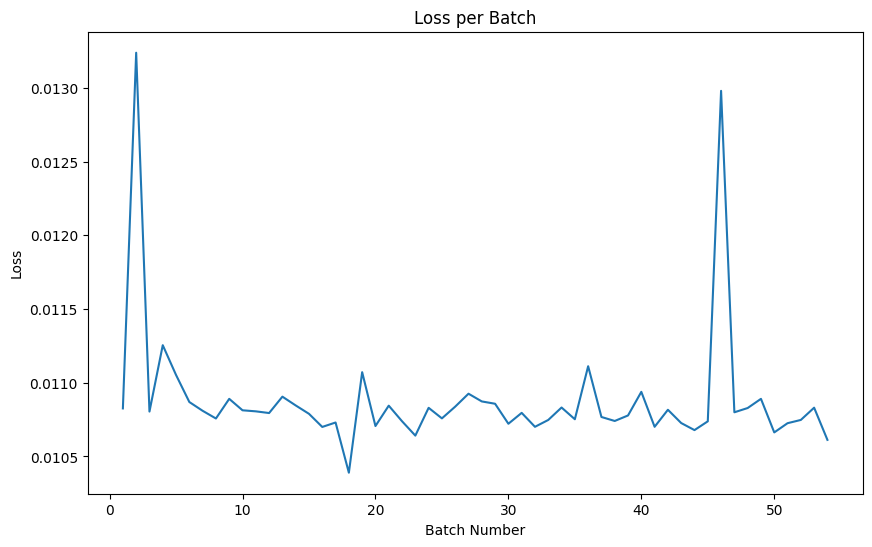

In [50]:
batch_numbers = range(1, len(batch_loss) + 1)

plt.figure(figsize=(10, 6))
sns.lineplot(x=batch_numbers, y=batch_loss)
plt.xlabel('Batch Number')
plt.ylabel('Loss')
plt.title('Loss per Batch')
plt.show()

In [87]:
VGG11_model.eval()
with torch.no_grad():
    true_labels = []
    predictions = []
    for class_tensor, img_tensor, bbox_tensor, label_tensor in train_dataloader:
        inputs = img_tensor
        targets = label_tensor.squeeze()
        true_labels.extend(targets)
        logits = VGG11_model(inputs)
        probabilities = torch.nn.functional.softmax(logits, dim=1)
        predicted_classes = torch.argmax(probabilities, dim=1)
        predictions.extend(predicted_classes.cpu().numpy())

/opt/homebrew/lib/python3.10/site-packages/torch/nn/functional.py:1347: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Text(0.5, 1.0, 'Confusion matrix for self-trained model')

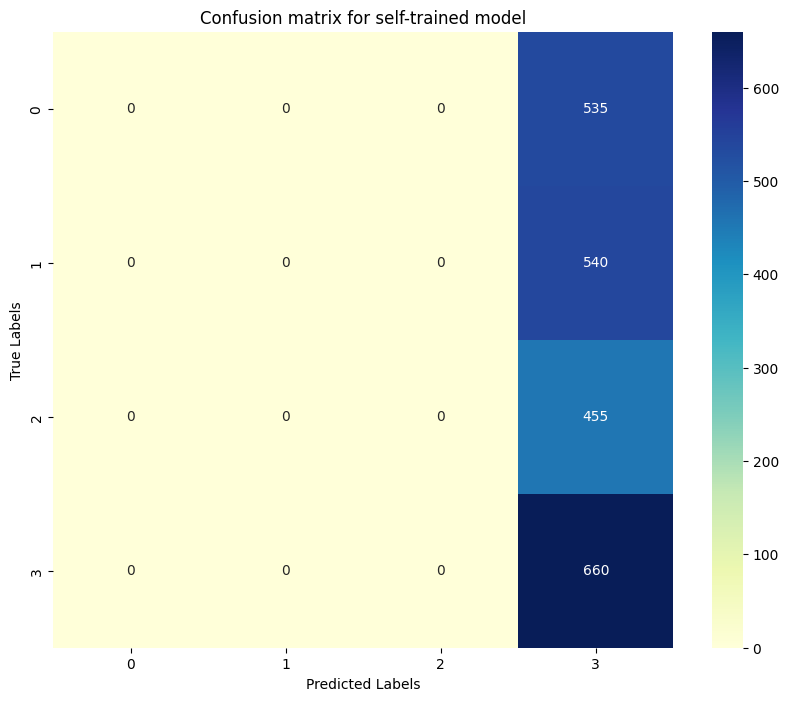

In [88]:
conf_matrix = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, cmap="YlGnBu", fmt='d')

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion matrix for self-trained model')


## Transfer learning using pre-trained model

In [76]:
vgg11 = models.vgg11(pretrained=True)
vgg11.parameters

<bound method Module.parameters of VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, paddin

In [78]:
in_features = vgg11.classifier[6].in_features
vgg11.classifier[6] = torch.nn.Linear(in_features, 4)
vgg11.features[0] = torch.nn.Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
vgg11.parameters

<bound method Module.parameters of VGG(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, paddin

In [79]:
for name, param in vgg11.named_parameters():
    if name == 'classifier.6.weight' or name == 'classifier.6.bias':
        param.requires_grad = True
    else:
        param.requires_grad = False
total_params = sum(p.numel() for p in vgg11.parameters())
print("Total parameters:", total_params)
total_trainable_params = sum(
    p.numel() for p in vgg11.parameters() if p.requires_grad)
print("Trainable parameters:", total_trainable_params)

Total parameters: 128781572
Trainable parameters: 16388


In [82]:
batch_loss = []
vgg11.train()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vgg11.parameters(), lr=0.001)
epochs = 3
for epoch in range(1, epochs+1):
    for class_tensor, img_tensor, bbox_tensor, label_tensor in tqdm(train_dataloader):
        inputs = img_tensor
        targets = label_tensor.squeeze()
        optimizer.zero_grad()
        logits = vgg11(inputs)
        loss = criterion(logits, targets)
        loss_number = loss.detach().numpy()
        batch_loss.append(loss_number/128)
        loss.backward()
        optimizer.step()

100%|██████████| 18/18 [00:26<00:00,  1.48s/it]


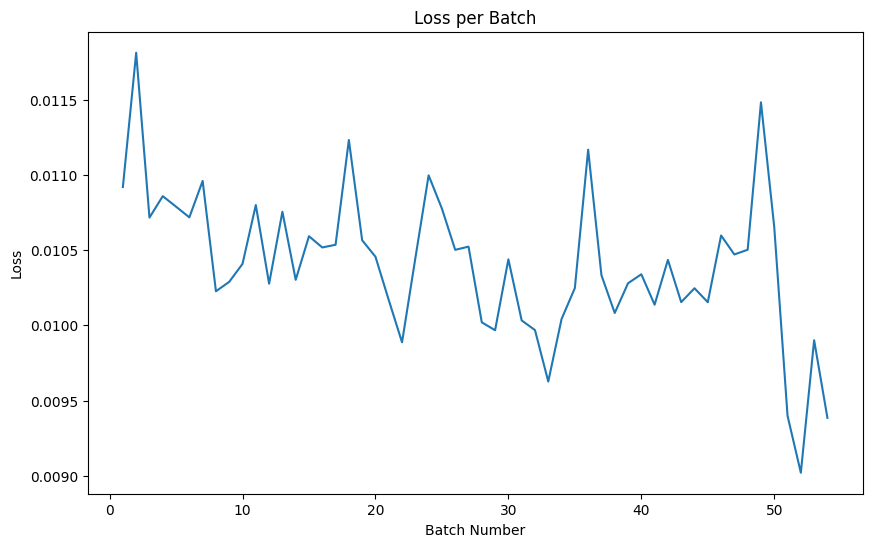

In [83]:
batch_numbers = range(1, len(batch_loss) + 1)

plt.figure(figsize=(10, 6))
sns.lineplot(x=batch_numbers, y=batch_loss)
plt.xlabel('Batch Number')
plt.ylabel('Loss')
plt.title('Loss per Batch')
plt.show()

In [84]:
vgg11.eval()
with torch.no_grad():
    true_labels = []
    predictions = []
    for class_tensor, img_tensor, bbox_tensor, label_tensor in train_dataloader:
        inputs = img_tensor
        targets = label_tensor.squeeze()
        true_labels.extend(targets)
        logits = vgg11(inputs)
        probabilities = torch.nn.functional.softmax(logits, dim=1)
        predicted_classes = torch.argmax(probabilities, dim=1)
        predictions.extend(predicted_classes.cpu().numpy())

Text(0.5, 1.0, 'Confusion matrix for self-trained model')

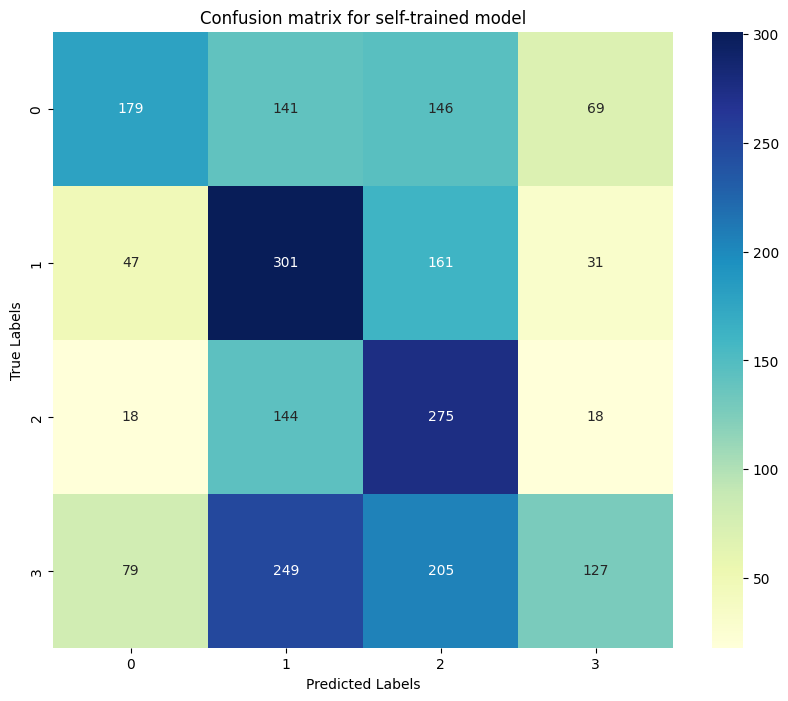

In [86]:
conf_matrix = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, cmap="YlGnBu", fmt='d')

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion matrix for pre-trained model')